In [1]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
import json

In [35]:
ground_truth = pl.read_csv('../experiments/experiment60/result.csv')
# ground_truth = pl.read_csv('../data/new_pws_estimate.csv')
mlpws_result = pl.read_csv('../experiments/experiment58/result.csv')
# mlpws_result = pl.read_csv('../data/new_mlpws_estimate.csv')
doe_result = pl.read_csv('../experiments/experiment41/result.csv')
infonce_result = pl.read_csv('../experiments/experiment42/result.csv')

In [36]:
with open("../data/ar_data2.json", "r") as file:
    json_data = json.load(file)

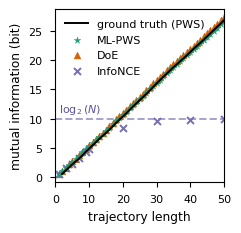

In [37]:
plt.style.use('seaborn-v0_8-paper')

width = 160 / 72
height = 160 / 72

colors = plt.get_cmap('Dark2').colors

with plt.rc_context({'font.size': 8, 'lines.markersize': 5}):
    fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True)
    ax.set_prop_cycle(plt.cycler(color=colors))
    ax.plot(ground_truth['step'] + 1, ground_truth['mean'] / np.log(2), label="ground truth (PWS)", color='black', zorder=3)
    ax.scatter(mlpws_result['step'], mlpws_result['mean'] / np.log(2), marker='*', label="ML-PWS", zorder=2)
    # ax.plot(json_data['Time'], json_data['MutualInformation'] / np.log(2), label="ground truth (PWS)", color='black')
    ax.scatter(doe_result['step'], doe_result['mean'] / np.log(2), marker='^', label="DoE", zorder=1)
    # 
    ax.scatter(infonce_result['step'], infonce_result['mean'] / np.log(2), label="InfoNCE", marker='x')
    ax.axhline(np.log2(1000), color='#A6A3CE', linestyle='--', zorder=0)
    ax.text(1, np.log2(1000)+0.5, "$\\log_2(N)$", horizontalalignment='left', verticalalignment='bottom', color='#5B55A0')
    ax.legend(frameon=False)
    ax.set_xlabel('trajectory length')
    ax.set_ylabel('mutual information (bit)')
    ax.set_xlim(0, 50)

fig.savefig('../reports/figures/model_comparison.pdf')
fig

## Testing the statistical properties of input data

In [18]:
import torch
import numpy as np
from statsmodels.tsa.stattools import levinson_durbin
import json

EXP_NUM = 43

data = torch.load(f'../experiments/experiment{EXP_NUM}/input_data.pth')
with open(f'../experiments/experiment{EXP_NUM}/parameters.json', 'r') as file:
    params = json.load(file)
s = data['val_s']
x = data['val_x']
params

{'run_info': {'start_time': '2025-08-15T15:20:20.721355+00:00',
  'hostname': 'cluster-new.hollandia.amolf.nl'},
 'ar_coeffs': [0.5, -0.3, 0.2],
 'ar_std': 1.0,
 'gain': 1.0,
 'decay': 0.2,
 'output_noise': 0.2,
 'output_directory': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43',
 'result_path': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43/result.csv',
 'forward_epochs': 500,
 'backward_epochs': 100,
 'hidden_features': 64,
 'num_pairs': 1000,
 'length': 50,
 'seed': 0,
 'estimator': 'ML-PWS'}

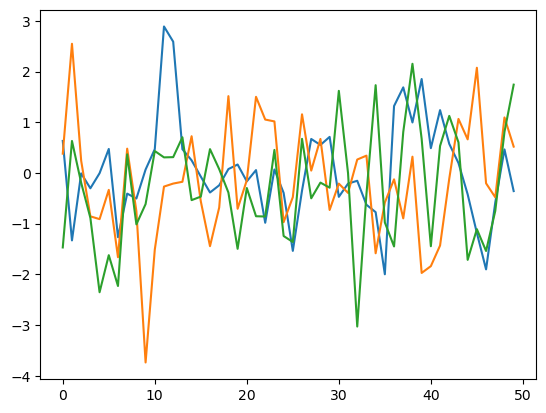

In [26]:
plt.plot(s[:3].T)

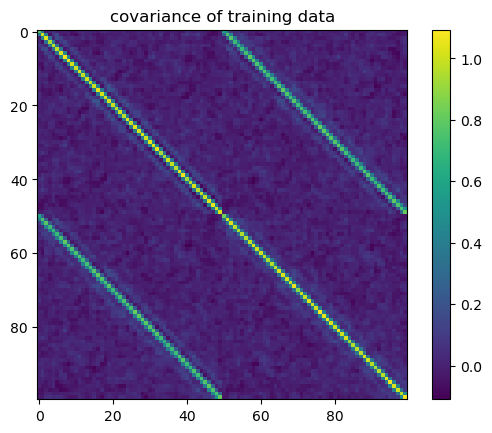

In [19]:
plt.imshow(np.cov(np.concat([s / s.std(), x / x.std()], axis=1).T))
plt.title('covariance of training data')
plt.colorbar()

Text(0.5, 0, 'lag')

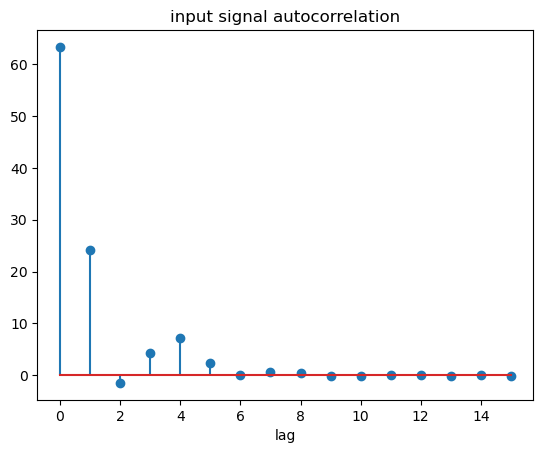

In [20]:
lags = np.arange(-s.shape[-1]+1, s.shape[-1])
max_lags = 15
acov = np.mean(np.stack([np.correlate(s, s, mode='full') for s in s]), axis=0)
pos = np.logical_and(lags >= 0, lags <= max_lags)
plt.stem(lags[pos], acov[pos])
plt.title('input signal autocorrelation')
plt.xlabel('lag')

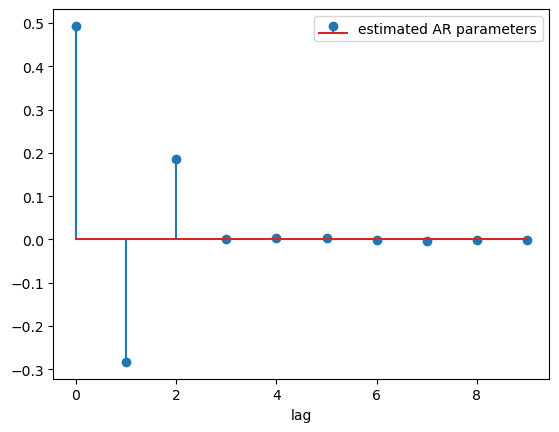

In [21]:
sigma_v, arcoefs, pacf, _, _ = levinson_durbin(acov[pos], isacov=True)
plt.stem(arcoefs, label='estimated AR parameters')
# plt.stem(params['ar_coeffs'], markerfmt='green', label='true AR parameters')
plt.xlabel('lag')
plt.legend()

<BarContainer object of 2 artists>

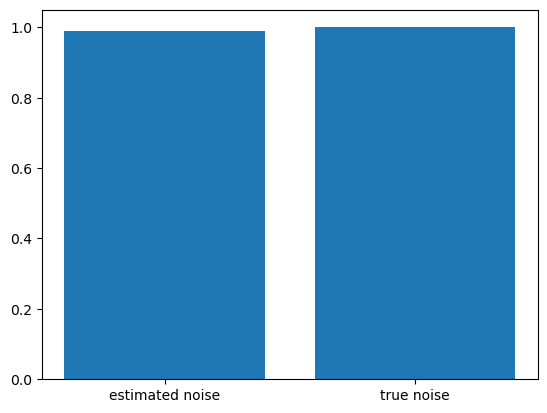

In [22]:
conv_params = np.insert(-np.array(params['ar_coeffs']), 0, 1)
residuals = np.zeros_like(s)
for i in range(residuals.shape[0]):
    residuals[i, :] = np.convolve(s[i], conv_params, mode='same')
plt.bar(['estimated noise', 'true noise'], [np.std(residuals), params['ar_std']])